In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
%mkdir content/drive/My\ Drive/maskdetection

mkdir: cannot create directory ‘content/drive/My Drive/maskdetection’: No such file or directory


In [14]:
%cd /content/drive/MyDrive/maskdetection

/content/drive/MyDrive/maskdetection


In [15]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1P9YgcPTZNufjC45YhtIJoGMz5Y4KtJfo' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1P9YgcPTZNufjC45YhtIJoGMz5Y4KtJfo" -O FILE && rm -rf /tmp/cookies.txt

--2021-05-07 08:24:33--  https://docs.google.com/uc?export=download&confirm=jMYr&id=1P9YgcPTZNufjC45YhtIJoGMz5Y4KtJfo
Resolving docs.google.com (docs.google.com)... 142.250.97.101, 142.250.97.100, 142.250.97.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.97.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-0k-docs.googleusercontent.com/docs/securesc/j86i0rg16l64571g4oc1ijcdlnslrh7k/8tp363vlln9tn611735imoi1vkaoviju/1620375825000/13528605597967313965/05412574852142372482Z/1P9YgcPTZNufjC45YhtIJoGMz5Y4KtJfo?e=download [following]
--2021-05-07 08:24:33--  https://doc-08-0k-docs.googleusercontent.com/docs/securesc/j86i0rg16l64571g4oc1ijcdlnslrh7k/8tp363vlln9tn611735imoi1vkaoviju/1620375825000/13528605597967313965/05412574852142372482Z/1P9YgcPTZNufjC45YhtIJoGMz5Y4KtJfo?e=download
Resolving doc-08-0k-docs.googleusercontent.com (doc-08-0k-docs.googleusercontent.com)... 173.194.214.132, 2607:f8b0:400c:c0b::84
Connectin

In [16]:
!unzip FILE

Archive:  FILE
  inflating: face_detector/deploy.prototxt  
  inflating: face_detector/res10_300x300_ssd_iter_140000.caffemodel  
  inflating: mask_detector.model     
  inflating: dataset/with_mask/with_mask651.jpeg  
  inflating: dataset/with_mask/with_mask641.jpeg  
  inflating: dataset/with_mask/with_mask649.jpeg  
  inflating: dataset/with_mask/with_mask638.jpeg  
  inflating: dataset/with_mask/with_mask645.jpeg  
  inflating: dataset/with_mask/with_mask648.jpeg  
  inflating: dataset/with_mask/with_mask650.jpeg  
  inflating: dataset/with_mask/with_mask659.jpeg  
  inflating: dataset/with_mask/with_mask654.jpeg  
  inflating: dataset/with_mask/with_mask647.jpeg  
  inflating: dataset/with_mask/with_mask653.jpeg  
  inflating: dataset/with_mask/with_mask637.jpeg  
  inflating: dataset/without_mask/augmented_image_25.jpg  
  inflating: dataset/with_mask/with_mask640.jpeg  
  inflating: dataset/with_mask/with_mask644.jpeg  
  inflating: dataset/with_mask/with_mask639.jpeg  
  inflat

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import imutils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2
from google.colab.patches import cv2_imshow
from imutils.video import VideoStream
import time
import sys

In [18]:
#Setting path to configuration file
prototxtPath = os.path.sep.join(["face_detector", "deploy.prototxt"])

#setting path to weights
weightsPath = os.path.sep.join(["face_detector",
	"res10_300x300_ssd_iter_140000.caffemodel"])

#Creating the network to detect faces
net = cv2.dnn.readNet(prototxtPath, weightsPath)

In [19]:
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
 
data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [20]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [21]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [22]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [23]:
LR = 1e-4     #learning rate
EPOCHS = 20    #no. of epochs
BS = 32       #batch size

#We will use Adam Optimizer for our model
opt= Adam(lr=LR, decay=LR / EPOCHS)

#To compile the model we use 'binary crossentropy' as loss function and set the metrics to accuracy
model.compile(loss="binary_crossentropy", optimizer=opt,
metrics=["accuracy"])

In [24]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [25]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
95/95 [==============================] - 167s 2s/step - loss: 0.6041 - accuracy: 0.7115 - val_loss: 0.1693 - val_accuracy: 0.9752
Epoch 2/20
95/95 [==============================] - 163s 2s/step - loss: 0.1827 - accuracy: 0.9581 - val_loss: 0.0942 - val_accuracy: 0.9791
Epoch 3/20
95/95 [==============================] - 164s 2s/step - loss: 0.1119 - accuracy: 0.9729 - val_loss: 0.0725 - val_accuracy: 0.9844
Epoch 4/20
95/95 [==============================] - 163s 2s/step - loss: 0.0860 - accuracy: 0.9764 - val_loss: 0.0610 - val_accuracy: 0.9844
Epoch 5/20
95/95 [==============================] - 164s 2s/step - loss: 0.0648 - accuracy: 0.9813 - val_loss: 0.0541 - val_accuracy: 0.9844
Epoch 6/20
95/95 [==============================] - 164s 2s/step - loss: 0.0621 - accuracy: 0.9816 - val_loss: 0.0476 - val_accuracy: 0.9870
Epoch 7/20
95/95 [==============================] - 165s 2s/step - loss: 0.0506 - accuracy: 0.9873 - val_loss: 0.0437 - val_accuracy: 0.9896
Epoch 8/20
95

In [26]:
preds = model.evaluate(testX, testY)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

24/24 [==============================] - 27s 1s/step - loss: 0.0307 - accuracy: 0.9896
Loss = 0.03074040450155735
Test Accuracy = 0.9895697236061096


In [27]:
model.save("model", save_format="h5")


In [28]:
model = load_model("mask_detector.model")

In [46]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [47]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [48]:
image_file = take_photo()

<IPython.core.display.Javascript object>

400 300


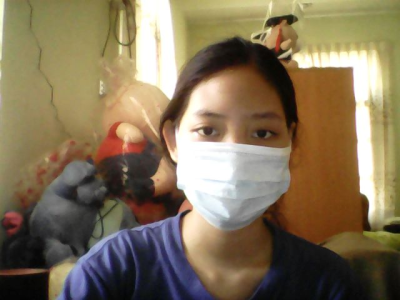

In [49]:
image = cv2.imread(image_file)

# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

In [50]:
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

In [51]:
net.setInput(blob)
detections = net.forward()

In [52]:
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]

	# filter. out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

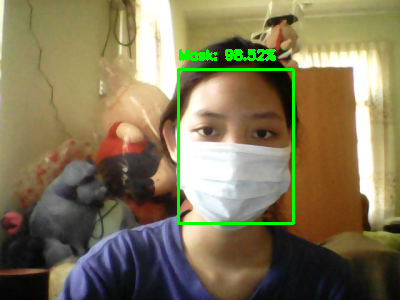

In [53]:
cv2_imshow(image)

In [64]:
!pip install ffmpeg-python


In [74]:
import io
import ffmpeg
from IPython.display import HTML


In [75]:
video_file= '/content/drive/My Drive/maskdetection/train.mp4'

In [76]:
VIDEO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var my_btn_txt = document.createTextNode("Press to start recording");

my_btn.appendChild(my_btn_txt);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, videoStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  videoStream = stream;
  var options = {  
    mimeType : 'video/webm;codecs=vp9'  
  };            
  recorder = new MediaRecorder(stream, options);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('video');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({video: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      videoStream.getVideoTracks()[0].stop();
      recordButton.innerText = "Original recording"
  }
}

function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available
  resolve(base64data.toString())

});

}
});
      
</script>
"""
def start_webcam():
  js = Javascript('''
    async function startWebcam() {
      const div = document.createElement('div');

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      
      return;

    }
    ''')
  
  display(js)
  data = eval_js('startWebcam()')

#start_webcam()

def get_video():
  display(HTML(VIDEO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  return binary

<IPython.core.display.Javascript object>

In [77]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)
  # return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

In [78]:
maskNet = load_model("mask_detector.model")

In [79]:
vid = get_video()

with open(video_file, 'wb') as f:
  f.write(vid)
print("Recorded the video")


video = cv2.VideoCapture('train.mp4')
out = cv2.VideoWriter('out.avi', cv2.VideoWriter_fourcc(*'XVID'), 20.0, (640,480))
# print(type(out))


while True:
			# grab the frame from the threaded video stream and resize it
			# to have a maximum width of 400 pixels
			# frame = vs.read()
			# frame = imutils.resize(frame, width=400)
		boool, frame = video.read()
		
		if(boool==False):
			break
		w, h, c = frame.shape

		#syntax: cv2.resize(img, (width, height))
		frame = cv2.resize(frame,(h, w))

		# detect faces in the frame and determine if they are wearing a
		# face mask or not
		locs, preds = detect_and_predict_mask(frame, net, maskNet)
		# loop over the detected face locations and their corresponding
		# locations

	 
		for (box, pred) in zip(locs, preds):
					# unpack 	# frame = vs.read()
					# frame = imutils.resize(frame, width=400)the bounding box and predictions
					(startX, startY, endX, endY) = box
					(mask, withoutMask) = pred

					# determine the class label and color we'll use to draw
					# the bounding box and text
					label = "Mask" if mask > withoutMask else "No Mask"
					color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

					# include the probability in the label
					label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

					# display the label and bounding box rectangle on the output
					# frame
					cv2.putText(frame, label, (startX, startY - 10),
					cv2.FONT_HERSHEY_COMPLEX, 0.55, color, 2)
					cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

		# show the output frame
		out.write(frame)
		# cv2_imshow(frame)
out.release()
# do a bit of cleanup
cv2.destroyAllWindows()

print("Detection complete.Now converting")

!ffmpeg -i out.avi output.mp4 -loglevel quiet -y 

from IPython.display import HTML
from base64 import b64encode
mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Recorded the video
Detection complete.Now converting
